In [1]:
from keras import models, layers
from ngdlm import models as ngdlmodels
from ngdlm import utils as ngdlutils
from keras.datasets import mnist
import numpy as np

Using TensorFlow backend.
/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Train and test data.

In [2]:
(x_input_train, _), (x_input_test, y_output_test) = mnist.load_data()
x_input_train = x_input_train.astype("float32") / 255.0
x_input_test = x_input_test.astype("float32") / 255.0
print(x_input_train.shape)
print(x_input_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
input_shape = (28, 28)
latent_dim = 128

encoder_input = layers.Input(shape=input_shape)
encoder_output = encoder_input
encoder_output = layers.Reshape(input_shape + (1,))(encoder_input)
encoder_output = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(encoder_output)
encoder_output = layers.MaxPooling2D((2, 2), padding="same")(encoder_output)
encoder_output = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(encoder_output)
encoder_output = layers.MaxPooling2D((2, 2), padding="same")(encoder_output)
encoder_output = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(encoder_output)
encoder_output = layers.MaxPooling2D((2, 2), padding="same")(encoder_output)
encoder_output = layers.Flatten()(encoder_output)
encoder = models.Model(encoder_input, encoder_output)

# Create the decoder.
decoder_input = layers.Input(shape=(latent_dim,))
decoder_output = decoder_input
#decoder_output = layers.Dense(128, activation="relu")(decoder_output)
decoder_output = layers.Reshape((4, 4, 8))(decoder_output)
decoder_output = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(decoder_output)
decoder_output = layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(decoder_output)
decoder_output = layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = layers.Conv2D(16, (3, 3), activation="relu")(decoder_output)
decoder_output = layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(decoder_output)
decoder_output = layers.Reshape((28, 28))(decoder_output)
decoder = models.Model(decoder_input, decoder_output)

# Create the VAE.
vae = ngdlmodels.VAE(encoder, decoder, latent_dim=latent_dim)
vae.compile(optimizer='adadelta', loss="binary_crossentropy")
vae.summary()

# Train.
print("Train...")
history = vae.fit(
        x_input_train, x_input_train,
        epochs=100,
        batch_size=32,
        shuffle=True,
        validation_data=(x_input_test, x_input_test)
    )
    
# Evaluate.
print("Evaluate...")
loss = vae.evaluate(x_input_test, x_input_test)
print("Loss:", loss)

Encoder:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   160         reshape_1[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
c

60000/60000 [==============================] - 87s 1ms/step - loss: 0.1669 - val_loss: 0.1652
Epoch 28/100
60000/60000 [==============================] - 87s 1ms/step - loss: 0.1667 - val_loss: 0.1656
Epoch 29/100
60000/60000 [==============================] - 85s 1ms/step - loss: 0.1664 - val_loss: 0.1661
Epoch 30/100
60000/60000 [==============================] - 85s 1ms/step - loss: 0.1665 - val_loss: 0.1637
Epoch 31/100
60000/60000 [==============================] - 86s 1ms/step - loss: 0.1663 - val_loss: 0.1631
Epoch 32/100
60000/60000 [==============================] - 84s 1ms/step - loss: 0.1661 - val_loss: 0.1658
Epoch 33/100
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1659 - val_loss: 0.1643
Epoch 34/100
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1657 - val_loss: 0.1634
Epoch 35/100
60000/60000 [==============================] - 84s 1ms/step - loss: 0.1657 - val_loss: 0.1628
Epoch 36/100
60000/60000 [========================

# Visualizing.

Rendering history...


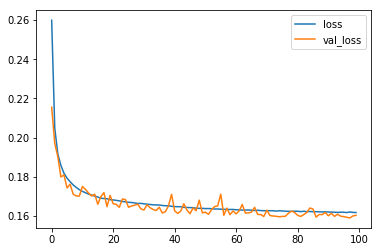

Rendering reconstructions...


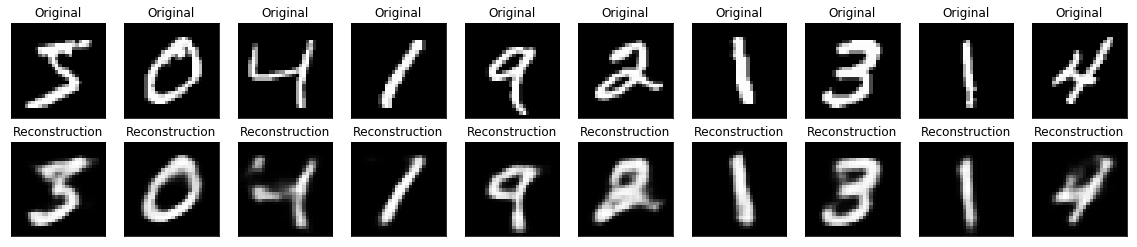

Rendering latent-space...


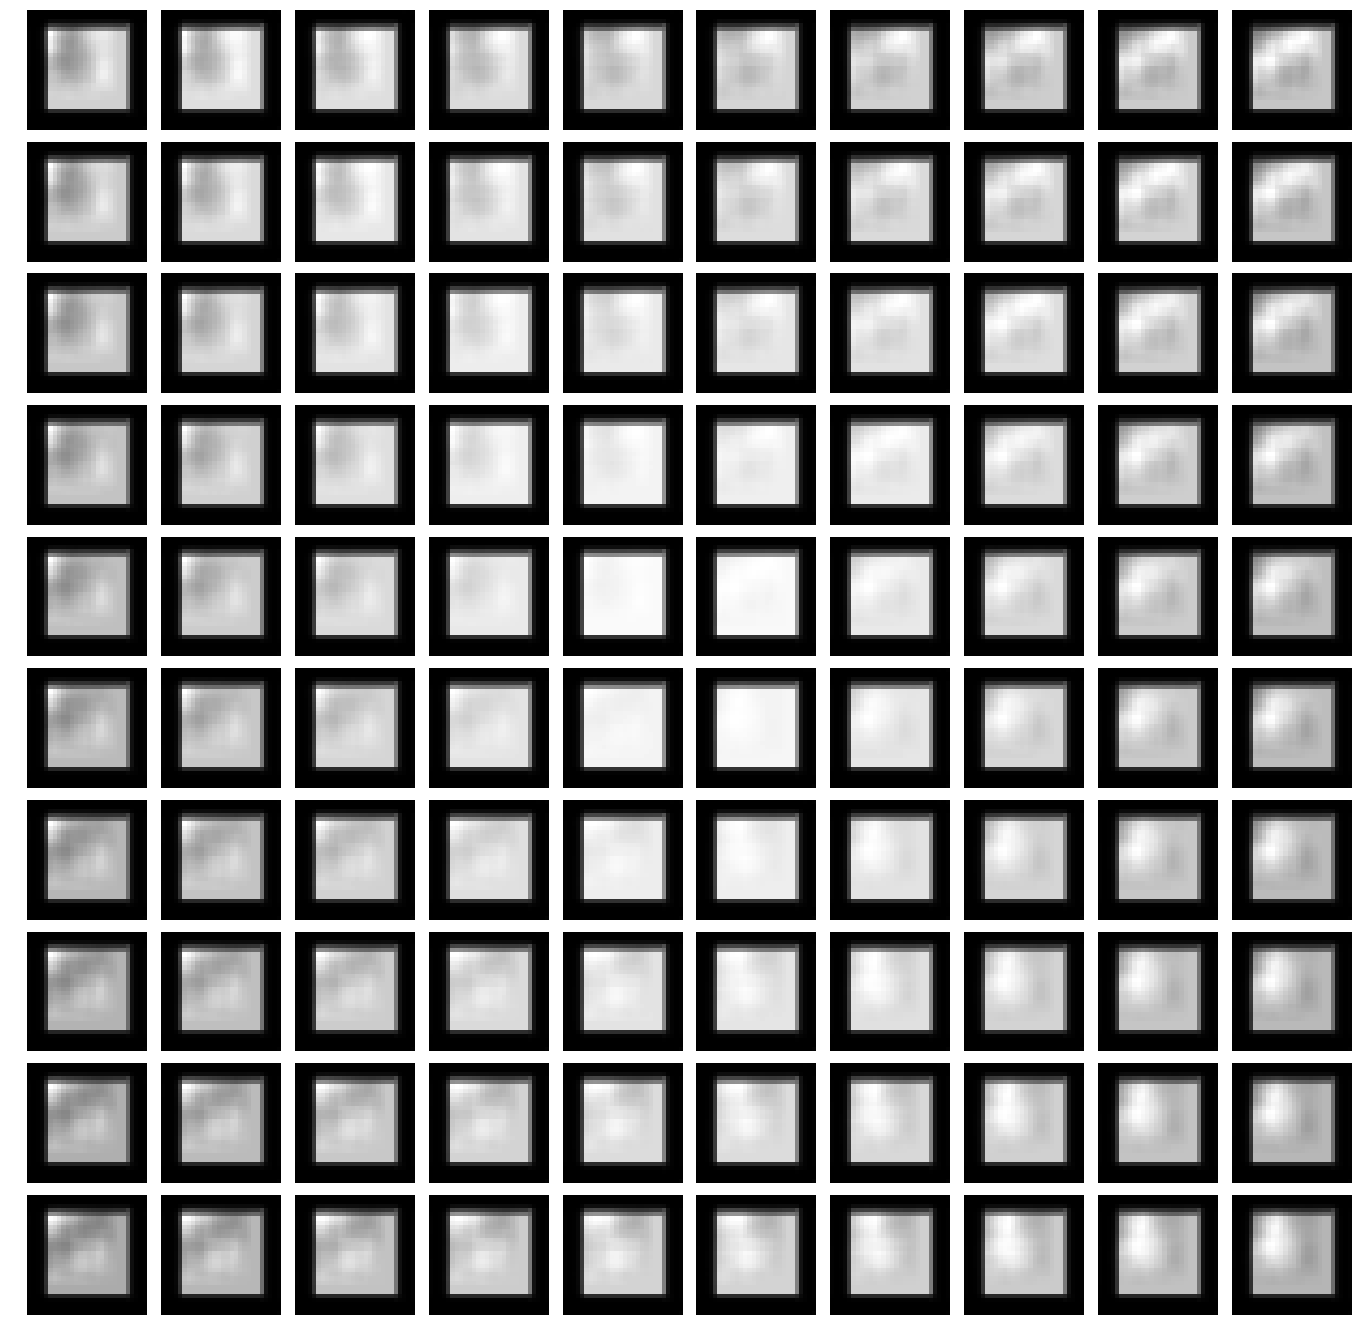

Rendering encodings...


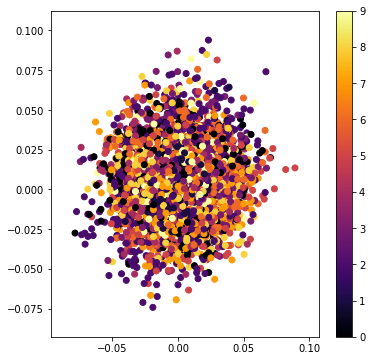

In [4]:
print("Rendering history...")
ngdlutils.render_history(history)

print("Rendering reconstructions...")
ngdlutils.render_image_reconstructions(vae, x_input_train[0:10])

print("Rendering latent-space...")
ngdlutils.render_image_latent_space(vae.decoder, 10)

print("Rendering encodings...")
ngdlutils.render_encodings(vae.encoder, x_input_test, y_output_test)